# 1 - Listado de variables y selección

## Entrada
* Manufacturer: Marca / fabricante del equipo
* Category: Tipo de notebook
* Screen Size: Tamaño diagonal de la pantalla en pulgadas
* Screen Type: Resolución y tipo de panel
* CPU: Modelo de procesador
* RAM: Capacidad de memoria
* Storage: Tipo y tamaño de almacenamiento interno
* GPU: Tipo y modelo de procesador de gráficos
* OS: Sistema operativo
* Weight: Peso

## Salida
* Price: Será reducida con rangos a valores "bajo", "medio" o "alto"

## No utilizadas
* Model Name: Texto arbitrario que generalmente no representa las capacidades del producto, y cuando lo hace meramente tiene agregados valores de otras columnas
* OS Version: No usada debido a su gran cantidad de nulos y presunta poca importancia

# 2 - Análisis detallado de un conjunto de variables

In [137]:
import pandas as pd

In [138]:
laptops_train = pd.read_csv('laptops_train.csv')
laptops_test = pd.read_csv('laptops_test.csv')

In [139]:
print("Entries de train: "+str(len(laptops_train)))
print("Entries de test: "+str(len(laptops_test)))

Entries de train: 977
Entries de test: 325


### Valores nulos

In [140]:
laptops_train.isnull().sum()

Manufacturer                  0
Model Name                    0
Category                      0
Screen Size                   0
Screen                        0
CPU                           0
RAM                           0
 Storage                      0
GPU                           0
Operating System              0
Operating System Version    136
Weight                        0
Price                         0
dtype: int64

In [141]:
laptops_test.isnull().sum()

Manufacturer                 0
Model Name                   0
Category                     0
Screen Size                  0
Screen                       0
CPU                          0
RAM                          0
 Storage                     0
GPU                          0
Operating System             0
Operating System Version    34
Weight                       0
Price                        0
dtype: int64

Este dataset solo presenta valores nulos en la columna "Operating System Version", la cual se decidió no utilizar anteriormente, por lo cual no es un problema a tener en cuenta en este caso

In [142]:
laptops_train

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Alienware 17,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,32GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows,10,4.42kg,24897600.00
973,Toshiba,Tecra A40-C-1DF,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows,10,1.95kg,10492560.00
974,Asus,Rog Strix,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows,10,2.73kg,18227710.80
975,HP,Probook 450,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.70GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce 930MX,Windows,10,2.04kg,8705268.00


In [143]:
# Renombre de las series
new_col_names = {
    "Manufacturer":"manufacturer",
    "Model Name":"model",
    "Category":"category",
    "Screen Size":"screen_size",
    "Screen":"display",
    "CPU":"cpu",
    "RAM":"gb_ram",
    " Storage":"storage", # la string original tiene el espacio, sin eso no lo cambia
    "GPU":"gpu",
    "Operating System":"os",
    "Operating System Version":"os_version",
    "Weight":"weight",
    "Price":"price"
}

dropped_cols = ["os_version", "model"]

laptops_train = laptops_train.rename(columns=new_col_names).drop(columns=dropped_cols)
laptops_test = laptops_test.rename(columns=new_col_names).drop(columns=dropped_cols)

In [144]:
laptops_train

,manufacturer,category,screen_size,display,cpu,gb_ram,storage,gpu,os,weight,price
0,Apple,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,11912523.48
1,Apple,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,7993374.48
2,HP,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,5112900.00
3,Apple,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,22563005.40
4,Apple,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,16037611.20
...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,32GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows,4.42kg,24897600.00
973,Toshiba,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows,1.95kg,10492560.00
974,Asus,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows,2.73kg,18227710.80
975,HP,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.70GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce 930MX,Windows,2.04kg,8705268.00


## Variable de salida

In [145]:
# Conversión de la variable de salida de rupias a dólares, tomando como base la cotización del 28/03/2023, según la última actualización del dataset
# Se dividió por 100 el valor obtenido debido a que los precios convertidos con la cotización de referencia se encontraban fuera del rango esperado
# Cotización: 1 INR = 0.0001217 USD


cotizacion = 0.0001217

def convertir_precio(precio):
    return int(precio * cotizacion)

laptops_train["price"] = laptops_train["price"].apply(convertir_precio)
laptops_test["price"] = laptops_test["price"].apply(convertir_precio)

In [146]:
laptops_train

,manufacturer,category,screen_size,display,cpu,gb_ram,storage,gpu,os,weight,price
0,Apple,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1449
1,Apple,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,972
2,HP,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,622
3,Apple,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2745
4,Apple,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1951
...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,32GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows,4.42kg,3030
973,Toshiba,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows,1.95kg,1276
974,Asus,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows,2.73kg,2218
975,HP,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.70GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce 930MX,Windows,2.04kg,1059


In [147]:
laptops_test

,manufacturer,category,screen_size,display,cpu,gb_ram,storage,gpu,os,weight,price
0,HP,Notebook,"15.6""",1366x768,Intel Core i7 7500U 2.7GHz,6GB,1TB HDD,Intel HD Graphics 620,Windows,2.04kg,626
1,Asus,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows,2.99kg,1892
2,Dell,2 in 1 Convertible,"15.6""",IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,12GB,512GB SSD,Intel HD Graphics 620,Windows,2.19kg,1405
3,Toshiba,Notebook,"13.3""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows,1.2kg,1293
4,Lenovo,Notebook,"15.6""",Full HD 1920x1080,AMD A12-Series 9720P 3.6GHz,6GB,256GB SSD,AMD Radeon 530,Windows,2.2kg,594
...,...,...,...,...,...,...,...,...,...,...,...
320,Lenovo,2 in 1 Convertible,"14.0""",IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows,1.8kg,690
321,Lenovo,2 in 1 Convertible,"13.3""",IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows,1.3kg,1622
322,Lenovo,Notebook,"14.0""",1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows,1.5kg,247
323,HP,Notebook,"15.6""",1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows,2.19kg,826


In [148]:
import matplotlib as plt
import plotly.express as px

In [149]:
px.histogram(laptops_train, x="price")

In [150]:
px.histogram(laptops_test, x="price")

In [151]:
px.box(laptops_train, x="price")

In [152]:
px.box(laptops_test, x="price")

In [153]:
laptops_train["price"].describe()

count     977.000000
mean     1218.808598
std       767.490421
min       207.000000
25%       648.000000
50%      1037.000000
75%      1596.000000
max      6600.000000
Name: price, dtype: float64

In [154]:
laptops_test["price"].describe()

count     325.000000
mean     1203.329231
std       723.305960
min       188.000000
25%       647.000000
50%      1082.000000
75%      1621.000000
max      4301.000000
Name: price, dtype: float64

Se puede apreciar como la variable de salida tiene una forma de campana gaussiana con asimetría positiva. Podemos notar como tanto el set de train y de test tienen una distribución similar, lo cual es importante controlar debido a que ambas tablas fueron provistas por el creador del dataset. A su vez se puede ver como existen valores anómalos y aberrantes en los rangos superiores del dataset. En consecuencia, esto podría generar overfitting debido a los pocos datos en este rango, y optamos por quitar estos dispositivos del dataset directamente.

In [155]:
# Descartamos los valores anómalos y aberrantes (donde precio > 3500)

descartes_train = laptops_train[laptops_train.price > 3500].index
descartes_test = laptops_test[laptops_test.price > 3500].index

laptops_train = laptops_train.drop(descartes_train)
laptops_test = laptops_test.drop(descartes_test)

print("Valores descartados:")
print("Train:"+str(len(descartes_train)))
print("Test:"+str(len(descartes_test)))

Valores descartados:
Train:8
Test:4


In [156]:
# Conversión a rangos de precios
# Rangos:
# low: 0 < price <= 1000
# mid: 1000 < price <= 1500
# high: 1500 < price <= 3500

laptops_train["price_range"] = pd.cut(x=laptops_train["price"], bins=[0, 1000, 1500, 3500], labels=["low", "mid", "high"])
laptops_test["price_range"] = pd.cut(x=laptops_test["price"], bins=[0, 1000, 1500, 3500], labels=["low", "mid", "high"])

In [157]:
# Ordenamos el dataset por la nueva columna de price_range para que los gráficos queden mejor acomodados
# (se puede hacer agregando category_orders={"price_range": ["low", "mid", "high"]} a cada gráfico, pero de esta manera aplica para todos)

laptops_train = laptops_train.sort_values(by="price_range")
laptops_test = laptops_test.sort_values(by="price_range")

In [158]:
laptops_train

,manufacturer,category,screen_size,display,cpu,gb_ram,storage,gpu,os,weight,price,price_range
279,Lenovo,Notebook,"17.3""",Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,2TB HDD,Nvidia GeForce MX150,No OS,2.8kg,918,low
705,Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,2.18kg,860,low
368,Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,AMD Radeon R7 M445,Windows,2.33kg,972,low
367,Lenovo,Gaming,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7300HQ 2.5GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050,No OS,2.4kg,875,low
365,HP,Notebook,"15.6""",1366x768,Intel Pentium Quad Core N3710 1.6GHz,8GB,2TB HDD,Intel HD Graphics 405,Windows,2.04kg,420,low
...,...,...,...,...,...,...,...,...,...,...,...,...
354,Toshiba,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Nvidia GeForce 930M,Windows,2.4kg,1518,high
359,Dell,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 7300U 2.6GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,1.36kg,1544,high
707,Lenovo,Workstation,"15.6""",Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Nvidia Quadro M520M,Windows,2.18kg,2007,high
746,Samsung,Ultrabook,"13.3""",Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,256GB SSD,Intel HD Graphics 620,Windows,0.81kg,1784,high


In [159]:
#Una ves aplicado los rangos, droppeamos la columna de precio, porque no la vamos a usar
laptops_train = laptops_train.drop(columns="price")
laptops_test = laptops_test.drop(columns="price")

In [160]:
laptops_train

,manufacturer,category,screen_size,display,cpu,gb_ram,storage,gpu,os,weight,price_range
279,Lenovo,Notebook,"17.3""",Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,2TB HDD,Nvidia GeForce MX150,No OS,2.8kg,low
705,Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,2.18kg,low
368,Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,AMD Radeon R7 M445,Windows,2.33kg,low
367,Lenovo,Gaming,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7300HQ 2.5GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050,No OS,2.4kg,low
365,HP,Notebook,"15.6""",1366x768,Intel Pentium Quad Core N3710 1.6GHz,8GB,2TB HDD,Intel HD Graphics 405,Windows,2.04kg,low
...,...,...,...,...,...,...,...,...,...,...,...
354,Toshiba,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Nvidia GeForce 930M,Windows,2.4kg,high
359,Dell,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 7300U 2.6GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,1.36kg,high
707,Lenovo,Workstation,"15.6""",Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Nvidia Quadro M520M,Windows,2.18kg,high
746,Samsung,Ultrabook,"13.3""",Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,256GB SSD,Intel HD Graphics 620,Windows,0.81kg,high


In [161]:
px.histogram(laptops_train, x = "price_range")

## Variables de entrada

### Manufacturer

In [162]:
px.histogram(laptops_train,x="manufacturer", color="price_range").update_xaxes(categoryorder="sum descending")

Se puede observar como el dataset cuenta en su mayoria con 4 manufacturadores predominantes, Lenovo, Dell, HP y Asus.

### Category

In [163]:
px.histogram(laptops_train, x="category", color="price_range").update_xaxes(categoryorder="sum descending")

Se observa como la mayoria de los datos ingresados tienen como categoria "Notebook". Ademas, la categoria "Workstation" contiene solo valores donde el rango de precio es "High" lo cual influira en la decision tomada por el modelo. Se puede notar tambien como las categorias "Gaming" y "Ultrabook" cuentan con muchos valores "mid" y "high", lo que tambien influye en las decisiones finales.

### Screen size

In [164]:
px.histogram(laptops_train, x="screen_size", color="price_range").update_xaxes(categoryorder="category ascending")

Se puede ver como la mayoria de los datos cuentan con un tamaño de pantalla de 15,6 pulgadas. Tambien se puede notar algunos datos individuales esparcidos entre los otros tamaños. A esta columna le aplicaremos una conversión de string a float, y dividimos arbitrariamente por 10 su valor

In [165]:
# Conversión de string a float

def convertir_tamanio_pantalla(tamanio):
    return float(tamanio[:-1])/10

laptops_train["screen_size"] = laptops_train["screen_size"].apply(convertir_tamanio_pantalla)
laptops_test["screen_size"] = laptops_test["screen_size"].apply(convertir_tamanio_pantalla)

In [166]:
px.histogram(laptops_train, x="screen_size", color="price_range")

### Display

In [167]:
px.histogram(laptops_train, x="display", color="price_range", height=600)

Esta columna posee valores conflictivos, debido a que varios términos representan lo mismo, y que estas strings no son útiles a la hora de entrenar un modelo, por lo cual esta columna será subdividida en 3:
* panel_res_x: resolución en el eje X
* panel_res_y: resolución en el eje Y
* panel_tech: lista de términos de features como "IPS" o "Touchscreen", usada luego como entrada de un count vectorizer

In [168]:
def obtener_pixeles_resolucion(display_string, axis):
    res_array = display_string.split()
    res = [substring for substring in res_array if "x" in substring][0]
    axis = 0 if axis == "x" else 1
    return int(res.split('x')[axis])

In [169]:
# Creación de la columna res_x

laptops_train.insert(4, "panel_res_x", laptops_train["display"].apply(obtener_pixeles_resolucion, args=("x")))
laptops_test.insert(4, "panel_res_x", laptops_test["display"].apply(obtener_pixeles_resolucion, args=("x")))

In [170]:
# Creación de la columna res_y

laptops_train.insert(5, "panel_res_y", laptops_train["display"].apply(obtener_pixeles_resolucion, args=("y")))
laptops_test.insert(5, "panel_res_y", laptops_test["display"].apply(obtener_pixeles_resolucion, args=("y")))

In [171]:
# Código auxiliar para detectar las posibles features de los displays del dataset

features = set()

for display in laptops_train["display"]:
     for word in display.split():
         features.add(word)

print(features)

{'3200x1800', '2256x1504', '/', '2736x1824', '3840x2160', '2560x1600', 'HD', '1440x900', '2880x1800', '2400x1600', '1600x900', 'Panel', 'Full', '2160x1440', 'Retina', 'Display', 'Ultra', '4K', 'IPS', 'Quad', 'Touchscreen', '1920x1200', '2560x1440', 'HD+', '1920x1080', '2304x1440', '1366x768'}


In [172]:
# Creación de la columna panel_tech

# features consideradas relevantes, dado que las resoluciones tienen sus columnas separadas y variantes de "HD" representan esos mismos números
features = ["IPS", "Touchscreen", "Retina"]

def obtener_features_panel(panel):
    panel_strings = panel.split()
    return " ".join([feature for feature in panel_strings if feature in features])

laptops_train.insert(6, "panel_tech", laptops_train["display"].apply(obtener_features_panel))
laptops_test.insert(6, "panel_tech", laptops_test["display"].apply(obtener_features_panel))

In [173]:
# Se elimina la columna "display" debido a que su información relevante ya fue transferida a las nuevas columnas

laptops_train = laptops_train.drop(columns="display")
laptops_test = laptops_test.drop(columns="display")

In [174]:
laptops_train

,manufacturer,category,screen_size,panel_res_x,panel_res_y,panel_tech,cpu,gb_ram,storage,gpu,os,weight,price_range
279,Lenovo,Notebook,1.73,1920,1080,,Intel Core i7 8550U 1.8GHz,8GB,2TB HDD,Nvidia GeForce MX150,No OS,2.8kg,low
705,Dell,Notebook,1.56,1920,1080,,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,2.18kg,low
368,Dell,Notebook,1.56,1920,1080,,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,AMD Radeon R7 M445,Windows,2.33kg,low
367,Lenovo,Gaming,1.56,1920,1080,IPS,Intel Core i5 7300HQ 2.5GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050,No OS,2.4kg,low
365,HP,Notebook,1.56,1366,768,,Intel Pentium Quad Core N3710 1.6GHz,8GB,2TB HDD,Intel HD Graphics 405,Windows,2.04kg,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,Toshiba,Notebook,1.56,1920,1080,IPS,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Nvidia GeForce 930M,Windows,2.4kg,high
359,Dell,Notebook,1.40,1920,1080,,Intel Core i5 7300U 2.6GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,1.36kg,high
707,Lenovo,Workstation,1.56,1920,1080,,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Nvidia Quadro M520M,Windows,2.18kg,high
746,Samsung,Ultrabook,1.33,1920,1080,,Intel Core i7 7500U 2.7GHz,16GB,256GB SSD,Intel HD Graphics 620,Windows,0.81kg,high


In [175]:
px.histogram(laptops_train, x="panel_res_x", color="price_range", height=600)

In [176]:
px.histogram(laptops_train, x="panel_res_y", color="price_range", height=400)

In [177]:
px.scatter_3d(laptops_train, x="panel_res_x", y="panel_res_y", z="price_range", color="price_range", height=600)

In [178]:
px.histogram(laptops_train, x="panel_tech", color="price_range", height=600)

### CPU

In [179]:
px.histogram(laptops_train, x="cpu", color="price_range", height=700)

Debido a la cantidad de ejemplares, y que estos son strings, se va a optar por separar la velocidad del procesador en una columna aparte, así como separar el modelo del fabricante, para así aplicar luego un one-hot encoder a este último:
* cpu_make
* cpu_model
* cpu_clockspeed

In [180]:
# Creación de la columna cpu_make

def obtener_marca_cpu(cpu_string):
    return cpu_string.split()[0]

laptops_train.insert(7, "cpu_make", laptops_train["cpu"].apply(obtener_marca_cpu))
laptops_test.insert(7, "cpu_make", laptops_test["cpu"].apply(obtener_marca_cpu))

In [181]:
# Creación de la columna cpu_model

def obtener_modelo_cpu(cpu_string):
    return " ".join(cpu_string.split()[1:-1])

laptops_train.insert(8, "cpu_model", laptops_train["cpu"].apply(obtener_modelo_cpu))
laptops_test.insert(8, "cpu_model", laptops_test["cpu"].apply(obtener_modelo_cpu))

In [182]:
# Creación de la columna cpu_clockspeed

def obtener_velocidad_cpu(cpu_string):
    return float(cpu_string.split()[-1].strip('GHz '))

laptops_train.insert(9, "cpu_clockspeed", laptops_train["cpu"].apply(obtener_velocidad_cpu))
laptops_test.insert(9, "cpu_clockspeed", laptops_test["cpu"].apply(obtener_velocidad_cpu))

In [183]:
# Se elimina la columna "cpu" debido a que su información relevante ya fue transferida a las nuevas columnas

laptops_train = laptops_train.drop(columns="cpu")
laptops_test = laptops_test.drop(columns="cpu")

In [184]:
laptops_train

,manufacturer,category,screen_size,panel_res_x,panel_res_y,panel_tech,cpu_make,cpu_model,cpu_clockspeed,gb_ram,storage,gpu,os,weight,price_range
279,Lenovo,Notebook,1.73,1920,1080,,Intel,Core i7 8550U,1.8,8GB,2TB HDD,Nvidia GeForce MX150,No OS,2.8kg,low
705,Dell,Notebook,1.56,1920,1080,,Intel,Core i5 7200U,2.5,8GB,256GB SSD,Intel HD Graphics 620,Windows,2.18kg,low
368,Dell,Notebook,1.56,1920,1080,,Intel,Core i7 7500U,2.7,8GB,256GB SSD,AMD Radeon R7 M445,Windows,2.33kg,low
367,Lenovo,Gaming,1.56,1920,1080,IPS,Intel,Core i5 7300HQ,2.5,8GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050,No OS,2.4kg,low
365,HP,Notebook,1.56,1366,768,,Intel,Pentium Quad Core N3710,1.6,8GB,2TB HDD,Intel HD Graphics 405,Windows,2.04kg,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,Toshiba,Notebook,1.56,1920,1080,IPS,Intel,Core i7 6500U,2.5,16GB,512GB SSD,Nvidia GeForce 930M,Windows,2.4kg,high
359,Dell,Notebook,1.40,1920,1080,,Intel,Core i5 7300U,2.6,8GB,256GB SSD,Intel HD Graphics 620,Windows,1.36kg,high
707,Lenovo,Workstation,1.56,1920,1080,,Intel,Core i7 6500U,2.5,16GB,512GB SSD,Nvidia Quadro M520M,Windows,2.18kg,high
746,Samsung,Ultrabook,1.33,1920,1080,,Intel,Core i7 7500U,2.7,16GB,256GB SSD,Intel HD Graphics 620,Windows,0.81kg,high


### RAM

In [185]:
px.histogram(laptops_train, x="gb_ram", color="price_range", barmode="group", category_orders={"gb_ram": ["2GB", "4GB", "6GB", "8GB", "12GB", "16GB", "24GB", "32GB"]})

Se puede apreciar como los rangos de precios ocupan mayoritariamente su segmento correspondiente, es decir, la mayoría de laptops con poca RAM se encuentran en el rango de precios bajos, aquellas con una cantidad media en el rango de precio medio, y las que tienen más capacidad de memoria en el rango de precio alto. Dado que todas las capacidades de memoria están listadas en GB, se pueden convertir a integer tranquilamente

In [186]:
# Conversión de RAM a integere

def convertir_ram_a_int(capacidad):
    return(int(capacidad[:-2]))

laptops_train["gb_ram"] = laptops_train["gb_ram"].apply(convertir_ram_a_int)
laptops_test["gb_ram"] = laptops_test["gb_ram"].apply(convertir_ram_a_int)

In [187]:
px.histogram(laptops_train, x="gb_ram", barmode="group", color="price_range")

### Storage

In [188]:
px.histogram(laptops_train, x="storage", color="price_range", height=600)

Para esta variable, dividiremos los GB de SSD y HDD en columnas separadas. Se eliminarán las entries que tengan almacenamiento listado como "Hybrid" ya que no se puede saber la cantidad de GB de cada medio. A su vez, los listados como "Flash Storage" serán tomados como GB de SSD.

In [189]:
# Quitamos las computadoras con almacenamiento "Híbrido"

descartes_train = laptops_train[laptops_train.storage.str.contains("Hybrid")].index
descartes_test = laptops_test[laptops_test.storage.str.contains("Hybrid")].index

laptops_train = laptops_train.drop(descartes_train)
laptops_test = laptops_test.drop(descartes_test)

print("Valores descartados:")
print("Train:"+str(len(descartes_train)))
print("Test:"+str(len(descartes_test)))

Valores descartados:
Train:2
Test:9


In [190]:
# Convertimos "Flash Storage" a "SSD"

def convertir_a_ssd(storage_string):
    return storage_string.replace("Flash Storage", "SSD")

laptops_train["storage"] = laptops_train["storage"].apply(convertir_a_ssd)
laptops_test["storage"] = laptops_test["storage"].apply(convertir_a_ssd)

In [191]:
# Función para obtener los GB de SSD y HDD

def separar_unidades_almacenamiento(storage_string, medio):
    if "+" in storage_string:
        storage_string = " ".join(storage_string.split("+"))
    storage_array = storage_string.split()
    
    if medio == "S" and "SSD" in storage_array:
        ssd = 0
        for index, string in enumerate(storage_array):
            if string == "SSD":
                drive_capacity = storage_array[index-1]
                multiplier = 1
                if "TB" in drive_capacity:
                    multiplier = 1024
                ssd += int(drive_capacity.strip('GTB ')) * multiplier
        return ssd
    
    if medio == "H" and "HDD" in storage_array:
        hdd = 0
        for index, string in enumerate(storage_array):
            if string == "HDD":
                drive_capacity = storage_array[index-1]
                multiplier = 1
                if "TB" in drive_capacity:
                    multiplier = 1024
                hdd += int(drive_capacity.strip('GTB ')) * multiplier
        return hdd
    return 0

In [192]:
# Creación de la columna gb_ssd

laptops_train.insert(11, "gb_ssd", laptops_train["storage"].apply(separar_unidades_almacenamiento, args=("S")))
laptops_test.insert(11, "gb_ssd", laptops_test["storage"].apply(separar_unidades_almacenamiento, args=("S")))

In [193]:
# Creación de la columna gb_hdd

laptops_train.insert(12, "gb_hdd", laptops_train["storage"].apply(separar_unidades_almacenamiento, args=("H")))
laptops_test.insert(12, "gb_hdd", laptops_test["storage"].apply(separar_unidades_almacenamiento, args=("H")))

In [194]:
# Se elimina la columna "storage" debido a que su información relevante ya fue transferida a las nuevas columnas

laptops_train = laptops_train.drop(columns="storage")
laptops_test = laptops_test.drop(columns="storage")

In [195]:
laptops_train

,manufacturer,category,screen_size,panel_res_x,panel_res_y,panel_tech,cpu_make,cpu_model,cpu_clockspeed,gb_ram,gb_ssd,gb_hdd,gpu,os,weight,price_range
279,Lenovo,Notebook,1.73,1920,1080,,Intel,Core i7 8550U,1.8,8,0,2048,Nvidia GeForce MX150,No OS,2.8kg,low
705,Dell,Notebook,1.56,1920,1080,,Intel,Core i5 7200U,2.5,8,256,0,Intel HD Graphics 620,Windows,2.18kg,low
368,Dell,Notebook,1.56,1920,1080,,Intel,Core i7 7500U,2.7,8,256,0,AMD Radeon R7 M445,Windows,2.33kg,low
367,Lenovo,Gaming,1.56,1920,1080,IPS,Intel,Core i5 7300HQ,2.5,8,128,1024,Nvidia GeForce GTX 1050,No OS,2.4kg,low
365,HP,Notebook,1.56,1366,768,,Intel,Pentium Quad Core N3710,1.6,8,0,2048,Intel HD Graphics 405,Windows,2.04kg,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,Toshiba,Notebook,1.56,1920,1080,IPS,Intel,Core i7 6500U,2.5,16,512,0,Nvidia GeForce 930M,Windows,2.4kg,high
359,Dell,Notebook,1.40,1920,1080,,Intel,Core i5 7300U,2.6,8,256,0,Intel HD Graphics 620,Windows,1.36kg,high
707,Lenovo,Workstation,1.56,1920,1080,,Intel,Core i7 6500U,2.5,16,512,0,Nvidia Quadro M520M,Windows,2.18kg,high
746,Samsung,Ultrabook,1.33,1920,1080,,Intel,Core i7 7500U,2.7,16,256,0,Intel HD Graphics 620,Windows,0.81kg,high


In [196]:
px.scatter_3d(laptops_train, x="gb_ssd", y="gb_hdd", z="price_range", color="price_range")

### GPU

In [197]:
px.histogram(laptops_train, x="gpu", color="price_range", height=600)

Las GPU mas caras resultan ser las pertenecientes a NVidia, aumentando el precio con las gpu mas modernas. La mas comun en el dataset son las de Intel HD Graphics.

### OS

In [198]:
px.histogram(laptops_train, x="os", color="price_range")

La gran mayoria de las laptops tiene como sistema operativo a Windows. Se aprecia una discrepancia al haber dos columnas de mac OS, lo cual resolvemos con la siguiente operación

In [199]:
# Normalización de nombres de macOS

def acomodar_nombre_os(nombre):
    if nombre == "Mac OS":
        nombre = "macOS"
    return nombre

laptops_train["os"] = laptops_train["os"].apply(acomodar_nombre_os)
laptops_test["os"] = laptops_test["os"].apply(acomodar_nombre_os)

In [200]:
px.histogram(laptops_train, x="os", color="price_range")

### Weight

In [201]:
px.histogram(laptops_train, x="weight", color="price_range").update_xaxes(categoryorder="category ascending")

En cuanto al peso, se puede notar como la mayoria de los equipos pesan 2.2kg, marcando su precio como "bajo".
Observando la grafica podemos ver como el precio aumenta extremos, manteniendose en un precio bajo en los pesos intermedios

In [202]:
# Conversión de pesos a floats

def convertir_peso(peso):
    return float(peso.strip('kgs '))

laptops_train["weight"] = laptops_train["weight"].apply(convertir_peso)
laptops_test["weight"] = laptops_test["weight"].apply(convertir_peso)

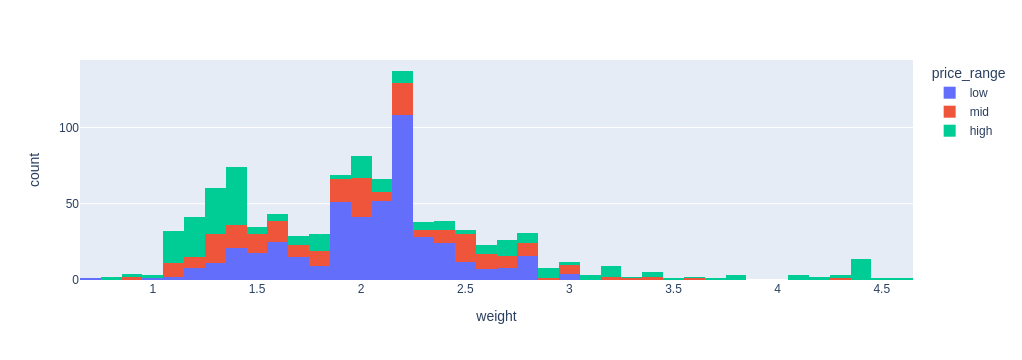

In [203]:
px.histogram(laptops_train, x="weight", color="price_range")

## Listado de dudas/preguntas para el proveedor del dataset

* De que fuentes provienen estos precios? y que metodos fueron utilizados para recolectarlos?
* Porque la columna de SO Type tiene tantos valores nulos?
* Pensas que el tipo de SO afecta al precio?
* Pensas que existen otros factores que afecten el precio de una laptop? como serían el material de chasis, distribución de teclado, etc.
* Cual crees que es la variable que mas afecta al precio de una laptop?
* Omitiste alguna variable al creear el dataset?

## 3 - Hipotesis sobre los datos

* Pensamos que la variable OS influye poco sobre el rango de precio final
* Creemos que las variables mas influyentes son GPU, Storage, RAM y CPU
* La variable Category se ve afectada principalmente por el GPU? 

## Comprobacion de la hipotesis

## Creacion de nuevas variables

## 4 - Modelado